In [27]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

## 0. Loading input data

In [28]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [29]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

# Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [30]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [31]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Lowering mutation rate

In [32]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -5
er_wt = -15

In [33]:
def get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                  ep_wt, er_wt, n_NS, n_p, n_r,
                  num_mutants=10000, mutrate=0.05, scaling_factor=100,
                  pseudocount=0, windowsize=3):
    df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                               ep_wt, er_wt, n_NS, n_p, n_r,
                               num_mutants=num_mutants,
                               mutrate=mutrate,
                               scaling_factor=scaling_factor)

    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                   pseudocount=pseudocount)

    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=windowsize)
    return footprint, exshift_list

In [8]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=10000, mutrate=0.1, scaling_factor=100,
                                        pseudocount=0, windowsize=3)

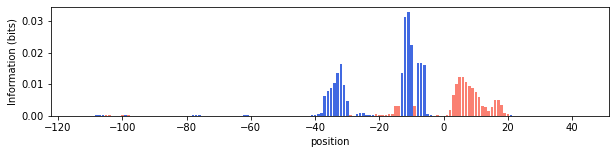

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [10]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=10000, mutrate=0.075, scaling_factor=100,
                                        pseudocount=0, windowsize=3)

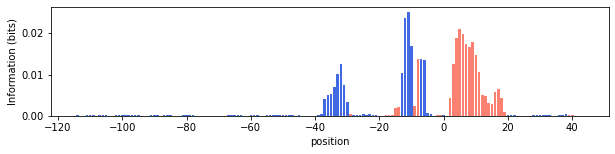

In [11]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [12]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=10000, mutrate=0.05, scaling_factor=100,
                                        pseudocount=0, windowsize=3)

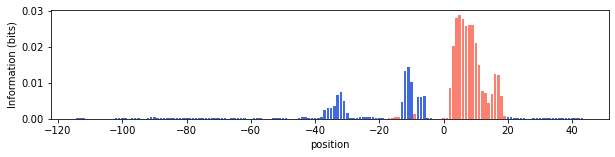

In [13]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [14]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=10000, mutrate=0.03, scaling_factor=100,
                                        pseudocount=10**(-6), windowsize=3)

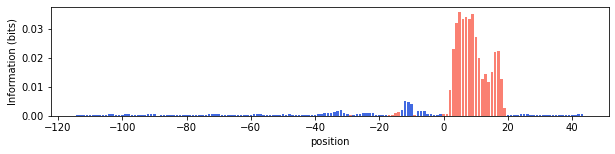

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

### Extreme case: what if we just have point mutations

In [16]:
def get_point_mutants(wtseq):
    mutants = []
    nts = ['A', 'T', 'C', 'G']
    for i, wt_nt in enumerate(wtseq):
        for nt in nts:
            if nt != wt_nt:
                mut = wtseq[:i] + nt + wtseq[(i + 1):]
                mutants.append(mut)
    return mutants

In [17]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, O1_emat, n_p, n_r, n_NS,
                  ep_wt, er_wt):

    l_simrep = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()
        rv['pbound'] = tregs.simulate.simrep_pbound(
                            rnap_mut, rep_mut, rnap_emat, O1_emat,
                            n_p, n_r, n_NS,
                            ep_wt=ep_wt, er_wt=er_wt)
        l_simrep.append(rv)
    df_simrep = pd.DataFrame.from_records(l_simrep)

    return df_simrep


def simrep_point_mutants(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
           ep_wt, er_wt, n_NS, n_p, n_r, scaling_factor=100):
    
    mutants = get_point_mutants(wtseq)
    
    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                          rnap_emat, O1_emat, n_p, n_r, n_NS, ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [18]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = simrep_point_mutants(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS, n_p, n_r)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

In [19]:
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

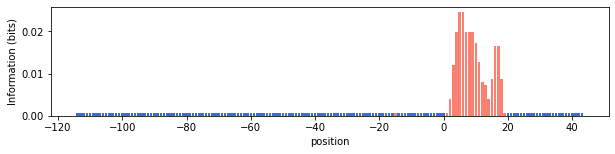

In [20]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

### Lowering mutation rate when library size is small

In [34]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=1000, mutrate=0.05, scaling_factor=100,
                                        pseudocount=10**(-6), windowsize=3)

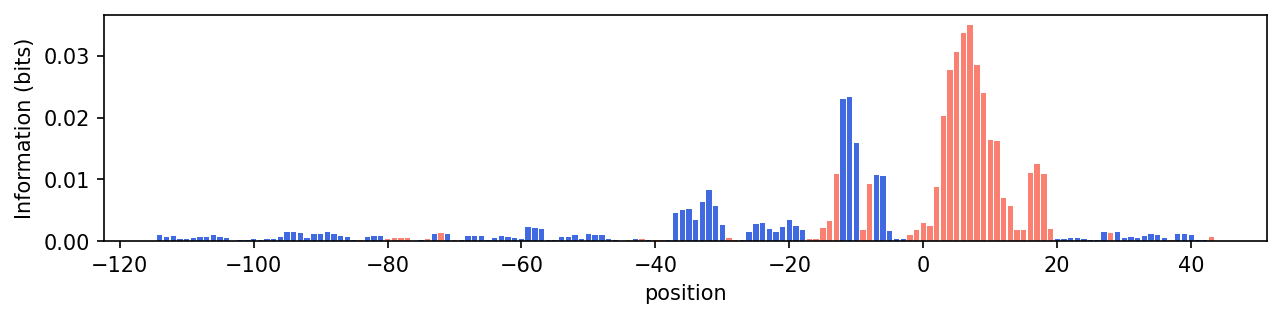

In [35]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [36]:
footprint, exshift_list = get_footprint(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                                        ep_wt, er_wt, n_NS, n_p, n_r,
                                        num_mutants=1000, mutrate=0.03, scaling_factor=100,
                                        pseudocount=10**(-6), windowsize=3)

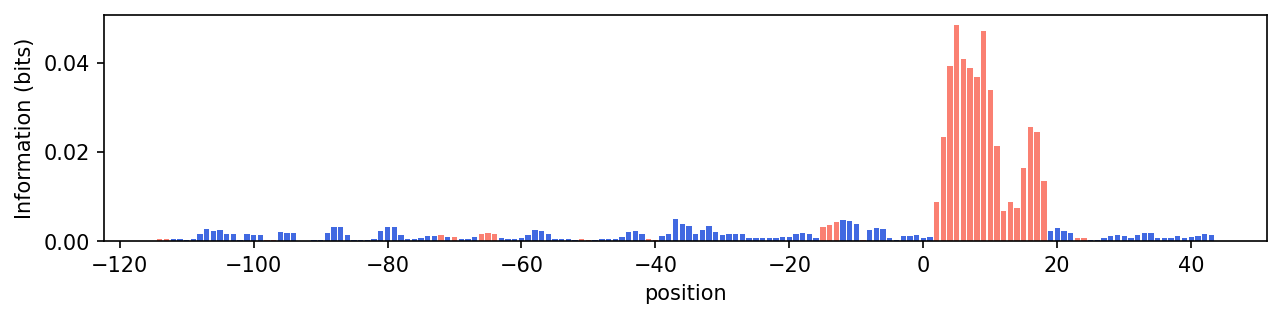

In [37]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()